- https://www.kaggle.com/davids1992/speech-visualization-and-exploration

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

TRAIN_PATH = './input/train/audio/'

# 1. Visualization

## 1.1. Wave and spectrogram:

In [2]:
file_path = os.path.join(TRAIN_PATH, 'yes/0a7c2a8d_nohash_0.wav')

In [3]:
sample_rate, samples = wavfile.read(file_path)

In [4]:
sample_rate, len(samples)

(16000, 16000)

In [5]:
samples[:10]

array([ 14,  -7, -14,   1,  12,   0, -14,  -8,  12,  22], dtype=int16)

In [6]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    '''
    Calculates Spectrogram.
    '''
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Note, that we are taking logarithm of spectrogram values. 
# It will make our plot much more clear, moreover, it is strictly connected to the way people hear. 
# We need to assure that there are no 0 values as input to logarithm.

- Frequencies are in range (0, 8000) according to [Niquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate).

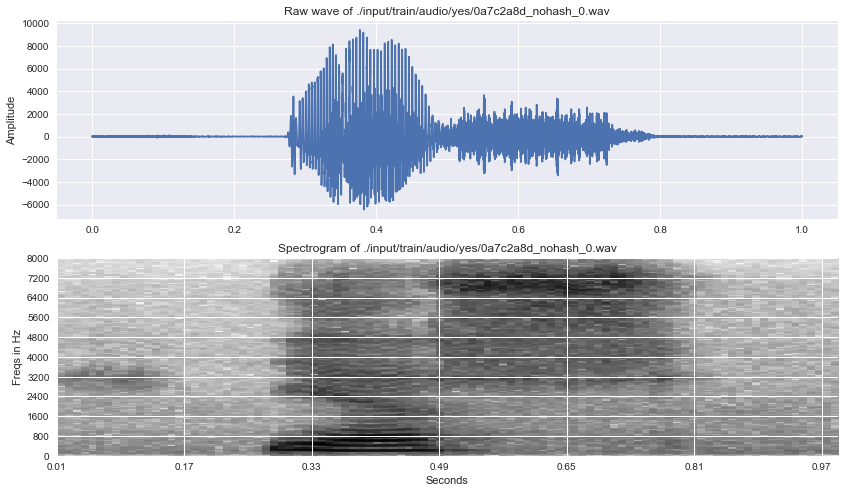

In [7]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_path)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + file_path)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [8]:
# If we use spectrogram as an input features for NN, we have to remember to normalize features. 
# (We need to normalize over all the dataset, here's example just for one, which doesn't give good mean and std!)
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

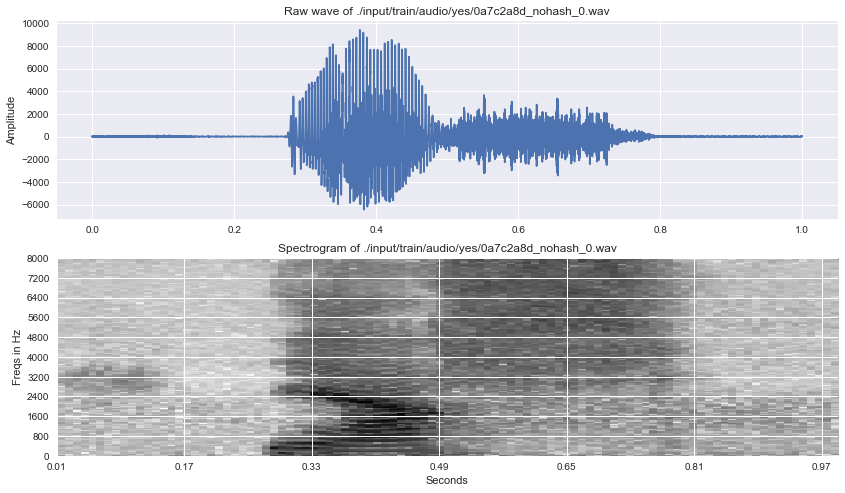

In [9]:
# freqs, times, spectrogram = log_specgram(sam/ples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_path)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + file_path)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [10]:
spectrogram[:10]

array([[ -1.08132392e-01,  -1.16584861e+00,  -6.40328228e-01, ...,
         -6.33536398e-01,  -1.04527795e+00,  -1.44986916e+00],
       [ -1.46231711e+00,  -1.89928830e+00,  -6.69235766e-01, ...,
         -8.76232803e-01,  -1.08390737e+00,  -8.91919732e-01],
       [ -7.98092604e-01,  -5.39569318e-01,  -6.03281260e-01, ...,
         -6.39476061e-01,  -5.45662582e-01,  -3.78962576e-01],
       ..., 
       [ -1.88588467e-03,  -8.33424032e-01,  -1.49382734e+00, ...,
         -8.77458870e-01,  -5.67579448e-01,  -2.95959830e-01],
       [ -3.34556639e-01,  -5.52480519e-01,  -5.41316748e-01, ...,
         -8.30894887e-01,  -7.76983380e-01,  -4.43515271e-01],
       [ -8.73844206e-01,  -1.99167565e-01,  -7.52618194e-01, ...,
         -8.11842561e-01,  -7.26471305e-01,  -4.50896204e-01]], dtype=float32)

## 1.2. MFCC
- https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

In [11]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
S[:2]

array([[  1.10254348e+04,   2.79904850e+03,   1.80273608e+02,
          2.86741060e+02,   6.35424955e+02,   1.57882793e+03,
          5.73562721e+02,   3.72986419e+02,   4.43585734e+04,
          9.34494997e+04,   1.61708716e+04,   3.67042191e+03,
          1.18435578e+04,   2.04602958e+04,   2.02381387e+04,
          2.16123091e+04,   2.12236465e+04,   8.08231504e+03,
          9.12115646e+02,   7.90887672e+02,   1.34745564e+03,
          1.24396732e+03,   1.45278697e+03,   8.79782401e+02,
          1.83795103e+02,   2.57604179e+02,   1.52117745e+02,
          1.69691262e+02,   5.26749217e+02,   5.05427754e+02,
          7.80124041e+03,   6.73888546e+04],
       [  1.43871056e+04,   4.29335928e+03,   2.64212331e+03,
          5.18006095e+03,   2.03937603e+03,   2.99182258e+03,
          4.24521084e+03,   1.63678399e+03,   1.18386777e+05,
          2.19340976e+05,   4.73186472e+04,   5.45099668e+04,
          1.54549749e+05,   1.99333450e+05,   1.40115399e+05,
          5.93584662e+04,

In [12]:
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
log_S[:2]

array([[-70.81770433, -76.77155735, -80.        , -80.        ,
        -80.        , -79.25831357, -80.        , -80.        ,
        -64.77188588, -61.53589178, -69.15432731, -75.5945017 ,
        -70.50683974, -68.1325425 , -68.17995591, -67.89464988,
        -67.97346156, -72.16630384, -80.        , -80.        ,
        -79.94651684, -80.        , -79.61964224, -80.        ,
        -80.        , -80.        , -80.        , -80.        ,
        -80.        , -80.        , -72.32002497, -62.95578084],
       [-69.66192729, -74.91368926, -77.02213077, -74.09831289,
        -78.14668849, -76.48230323, -74.96266894, -79.1017479 ,
        -60.50862962, -57.83046386, -64.49133838, -63.87690241,
        -59.35097854, -58.24585976, -59.7768029 , -63.50683489,
        -66.04806976, -64.35984888, -66.13772863, -73.73341986,
        -70.39257905, -68.30153351, -71.59479885, -70.61875282,
        -71.80581629, -74.85990365, -72.8320575 , -70.57303829,
        -73.67382133, -73.37424368, -72

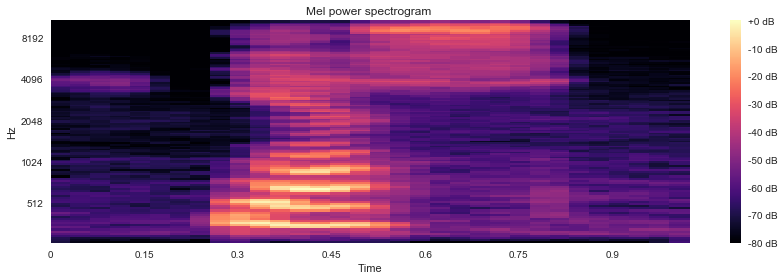

In [13]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

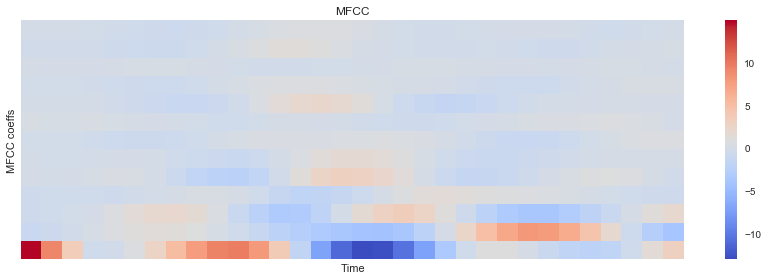

In [14]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## Spectrogram in 3d

In [15]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "yes" in 3d',
    scene = dict(
    yaxis = dict(title='Frequencies', range=freqs),
    xaxis = dict(title='Time', range=times),
    zaxis = dict(title='Log amplitude'),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 1.3. Silence removal

In [16]:
ipd.Audio(samples, rate=sample_rate)

In [21]:
# VAD (Voice Activity Detection) 
samples_cut = samples[4000:13000] # len(samples) -> 16000
ipd.Audio(samples_cut, rate=sample_rate)

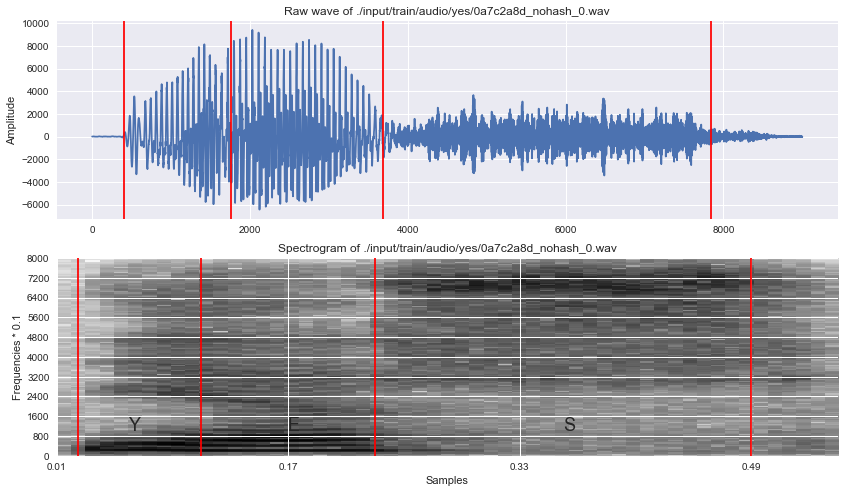

In [23]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_path)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + file_path)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.4. Resampling - dimensionality reduction

In [24]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [26]:
new_sample_rate = 8000
file_path = os.path.join(TRAIN_PATH, 'happy/0b09edd3_nohash_0.wav')

sample_rate, samples = wavfile.read(file_path)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [27]:
ipd.Audio(samples, rate=sample_rate)

In [28]:
ipd.Audio(resampled, rate=new_sample_rate)

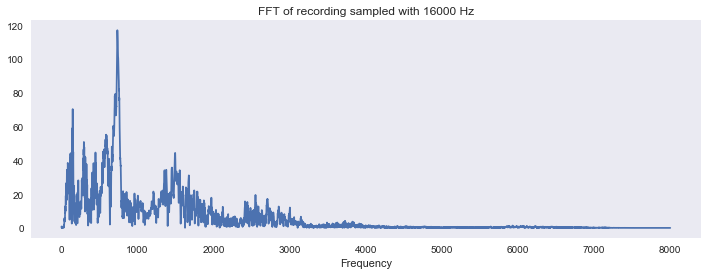

In [29]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

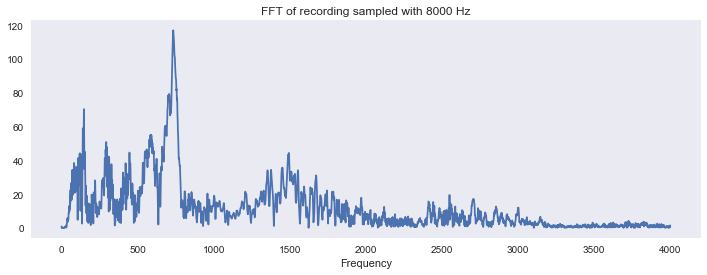

In [30]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()